## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import os
import json

from scipy.stats import gaussian_kde
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True

## Choose Model

#### roots

In [3]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

model_config = {}
plots_path = ''
dataset_path = ''
stan_file_path = ''
stan_output_dir = ''

#### read models configuration json file

In [4]:
with open("lba_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config['plots_folder_name'] + '/'
    dataset_path = datasets_root + model_config['dataset_name']
    stan_file_path = stan_files_root + model_config['stan_file']
    stan_output_dir = saved_models_root + model_config['model_name'] + '/'
    os.path
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('LBA', 'LBA_ct', 'LBA_cd', 'LBA_ndm', 'ANN-L…

In [6]:
model_config

{'model_name': 'ANN-LBA_full_s_FC',
 'stan_file': 'ANN-LBA/sigmoid_am_ndm.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'ANN-LBA_full_s_FC',
 'transf_params': ['transf_mu_k_word',
  'transf_mu_k_nonword',
  'transf_mu_sp_trial_var_word',
  'transf_mu_sp_trial_var_nonword',
  'transf_mu_g',
  'transf_mu_m',
  'transf_mu_alpha',
  'transf_mu_b',
  'transf_mu_theta_1',
  'transf_mu_theta_2',
  'transf_mu_drift_variability']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,thashbuckler,0,0,0.000000,NW,2.327570e-03,0.997672
1,citad,0,0,0.000000,NW,1.029650e-05,0.999990
2,recipus,0,0,0.000000,NW,5.357853e-05,0.999946
3,imducted,0,0,0.000000,NW,1.005859e-07,1.000000
4,suy,0,0,0.000000,NW,9.614917e-06,0.999990
...,...,...,...,...,...,...,...
74312,stave,253,1,2.547107,LF,9.991799e-01,0.000820
74313,lonclusions,0,0,0.000000,NW,8.465163e-05,0.999915
74314,profing,0,0,0.000000,NW,1.867627e-03,0.998132
74315,utbeknownst,0,0,0.000000,NW,5.369962e-03,0.994630


In [8]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + 'LDT_data_test.csv', header=None,  names=['accuracy', 'rt', 'string', 'response', 'participant', 'minRT'])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq"], axis=1)

In [9]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,1,0.465,tiebreuk,0,1,0.353,0.0,0.000000,NW,0.000012,0.999988
1,1,0.436,prefab,1,1,0.353,1.0,2.291834,LF,0.999765,0.000235
2,1,0.466,loodlum,0,1,0.353,0.0,0.000000,NW,0.000039,0.999961
3,1,0.457,needing,1,1,0.353,1.0,3.907784,HF,0.998165,0.001835
4,1,0.435,gallery,1,1,0.353,1.0,3.930323,HF,0.999875,0.000125


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [10]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                         non_word_prob  \
              mean       std count       max           min          mean   
category                                                                   
HF        0.996156  0.040583   708  1.000000  1.149608e-03      0.003844   
LF        0.989034  0.070395   946  1.000000  7.212390e-04      0.010966   
NW        0.006015  0.055780  2036  0.994248  2.928003e-13      0.993985   

                                                  
               std count       max           min  
category                                          
HF        0.040583   708  0.998850  4.185888e-11  
LF        0.070395   946  0.999279  6.951800e-12  
NW        0.055780  2036  1.000000  5.751547e-03

RT and response description of words and non-words in different conditions in all trials
across participants

In [11]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.679218  0.231042  1.902  0.225  0.932203  0.251574   1   0
LF        0.825617  0.325909  2.277  0.217  0.750529  0.432936   1   0
NW        0.842706  0.314375  2.450  0.253  0.149804  0.356966   1   0

## Stan Model and Estimation

Compiling stan model

In [12]:
lba_model = cmdstanpy.CmdStanModel(model_name=model_config['model_name'],
                                   stan_file=stan_file_path);

13:16:48 - cmdstanpy - INFO - compiling stan file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.stan to exe file D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
13:17:31 - cmdstanpy - INFO - compiled model executable: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan files\ANN-LBA\sigmoid_am_ndm.exe
13:17:31 - cmdstanpy - WARNING - Stan compiler has produced 34 warnings:
13:17:31 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Lenovo/AppData/Local/Temp/tmpwfn5xpca/tmp5whipu8k.hpp C:/Users/Lenovo/AppData/Local/Temp/tmpwfn5xpca/tmp5whipu8k.stan
Warning in 'C:/Users/Lenovo/AppData/Local/Temp/tmpwfn5xpca/tmp5whipu8k.stan', line 109, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
   

Preparing model's inputs

note that some inputs of data_dict might not be used depending on which model is used

In [13]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df['participant'].to_numpy()                     # For all models
p = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df['zipf'].to_numpy().astype(int)                  # zipf values For models with non-decision time or drift modulation
frequencyCondition = behavioural_df['category'].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df['response'].to_numpy().astype(int)               # for all models
rt = behavioural_df['rt'].to_numpy()                                       # for all models
minRT = behavioural_df['minRT'].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df['participant']))

k_priors = [0, 1, 1, 1]                  # All models with LBA
A_priors = [1, 2, 1, 1]                  # All models wtih LBA
ndt_priors = [0, 1, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models withoud drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
# There is a k parameter in LBA impelemention so we use theta as k parameter in sigmoid function
theta_priors = [2, 1, 1, 1]              # For models with sigmoid drift mapping functions (ANN-EAM models) (equivalent of k_priors in RDM and ANN-RDM)
sp_trial_var_priors = [1, 1, 0, 1]
drift_variability_priors = [1, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'frequency': frequency,
             'frequencyCondition': frequencyCondition,
             'k_priors': k_priors,
             'A_priors': A_priors,
             'ndt_priors': ndt_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'drift_priors': drift_priors,
             'p': p,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
             'theta_priors': theta_priors,
             'sp_trial_var_priors': sp_trial_var_priors,
             'drift_variability_priors': drift_variability_priors
             }

# set sampling parameters
n_iter = 500
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [14]:
fit = lba_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

13:17:54 - cmdstanpy - INFO - Chain [1] start processing
13:17:54 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 250
Chain [1] num_warmup = 250
Chain [2] method = sample (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [2] sample
Chain [1] gamma = 0.050000000000000003 (Default)Chain [2] num_samples = 250

Chain [1] delta = 0.80000000000000004 (Default)
Chain [2] num_warmup = 250Chain [1] kappa = 0.75 (Default)

Chain [1] t0 = 10 (Default)
Chain [2] save_warmup = 0 (Default)Chain [1] init_buffer = 75 (Default)

Chain [2] thin = 1 (Default)
Chain [1] term_buffer = 50 (Default)Chain [2] adapt

Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [1] window = 25 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [1] algorithm = hmc (Default)Chain [2] kappa = 0.75 (Default)
Chain [1] hmc

Chain [2] t0 = 10 (Default)Chain [1] engine = nuts (Default)
Chain [1] nuts

Chain [1] max_depth = 10 (Default)
Ch

13:51:39 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 1060.84 seconds (Warm-up)
Chain [1] 964.603 seconds (Sampling)
Chain [1] 2025.45 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [2] Iteration: 500 / 500 [100%]  (Sampling)


13:53:07 - cmdstanpy - INFO - Chain [2] done processing
13:53:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: tmp5whipu8k_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpwfn5xpca/tmp5whipu8k.stan', line 182, column 4 to column 37)
	Exception: tmp5whipu8k_model_namespace::log_prob: drift_word_t[1] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpwfn5xpca/tmp5whipu8k.stan', line 182, column 4 to column 37)
	Exception: tmp5whipu8k_model_namespace::log_prob: drift_word_t[378] is nan, but must be greater than or equal to 0.000000 (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpwfn5xpca/tmp5whipu8k.stan', line 182, column 4 to column 37)
	Exception: Exception: Exception: Phi: x is nan, but must be not nan! (in 'C:/Users/Lenovo/AppData/Local/Temp/tmpwfn5xpca/tmp5whipu8k.stan', line 25, column 8 to column 34) (in 'C:/Users/Lenovo/AppData/

Chain [2] 
Chain [2] Elapsed Time: 1175.99 seconds (Warm-up)
Chain [2] 936.944 seconds (Sampling)
Chain [2] 2112.93 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


## Model diagnostics

In [15]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_FC\ANN-LBA_full_s_FC-20221122131754_1.csv, D:\Cognitive modeling And ML\Thesis\ANN-EAM\stan_results\ANN-LBA_full_s_FC\ANN-LBA_full_s_FC-20221122131754_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [16]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-611.736000,0.832495,10.140700,-628.847000,-611.444000,-594.788000,148.380,0.078031,0.997756
mu_k_word,0.074166,0.015182,0.296768,-0.407050,0.070553,0.554567,382.119,0.200952,0.998409
mu_k_nonword,0.233226,0.021066,0.345642,-0.303931,0.203994,0.843052,269.201,0.141570,0.998151
mu_sp_trial_var_word,-0.027408,0.017093,0.350842,-0.562797,-0.041419,0.557179,421.295,0.221554,0.997163
mu_sp_trial_var_nonword,1.073550,0.036764,0.531550,0.258076,1.046750,1.950260,209.047,0.109935,1.008320
...,...,...,...,...,...,...,...,...,...
log_lik[3686],-1.774800,0.006549,0.151176,-2.026100,-1.770620,-1.539400,532.810,0.280198,0.996346
log_lik[3687],-1.622130,0.006384,0.147013,-1.871380,-1.617940,-1.388650,530.257,0.278855,0.996290
log_lik[3688],-2.081320,0.009612,0.216988,-2.446930,-2.075990,-1.762820,509.589,0.267987,1.001310
log_lik[3689],-2.193540,0.006588,0.157750,-2.472410,-2.189920,-1.939930,573.294,0.301488,1.001040


In [17]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
264


In [18]:
df.loc[df['R_hat']>1.01].to_csv('logs/'+model_config['model_name']+'_rhat_log.csv')

In [19]:
df.loc[df['R_hat']>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
z_sp_trial_var_nonword[4],-0.951270,0.027952,0.552638,-2.039060,-0.874668,-0.209144,390.894,0.205566,1.01380
drift_word_t[2212],0.499025,0.008063,0.136599,0.291417,0.492553,0.743948,287.043,0.150952,1.01053
drift_word_t[2214],0.499060,0.008063,0.136604,0.291440,0.492587,0.743993,287.041,0.150951,1.01053
drift_word_t[2216],0.520601,0.008264,0.139742,0.305284,0.514023,0.771226,285.935,0.150370,1.01024
drift_word_t[2219],0.499000,0.008062,0.136595,0.291401,0.492528,0.743916,287.044,0.150953,1.01053
...,...,...,...,...,...,...,...,...,...
log_lik[3259],0.379161,0.004189,0.082574,0.239317,0.379132,0.510093,388.597,0.204358,1.01200
log_lik[3286],-0.962079,0.007527,0.157158,-1.238380,-0.955841,-0.706591,435.917,0.229243,1.01314
log_lik[3293],-1.316580,0.008405,0.180585,-1.639070,-1.309710,-1.028180,461.651,0.242777,1.01053
log_lik[3303],-0.812410,0.007229,0.148638,-1.067910,-0.806763,-0.566308,422.788,0.222339,1.01423


In [20]:
df.loc[df['R_hat']>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.483037,0.007927,0.137771,0.268086,0.479198,0.723417,306.100375,0.160974,1.010949
std,0.511062,0.001916,0.035431,0.550656,0.508591,0.482486,45.222112,0.023782,0.001278
min,-2.421760,0.003670,0.073634,-2.702880,-2.407380,-2.163360,285.643000,0.150216,1.010010
25%,0.499007,0.008062,0.136596,0.291406,0.492535,0.743925,287.025750,0.150943,1.010520
50%,0.499119,0.008063,0.136609,0.291478,0.492646,0.744067,287.041000,0.150951,1.010530
75%,0.499878,0.008068,0.136694,0.291965,0.493394,0.745032,287.044000,0.150953,1.010530
max,1.853050,0.027952,0.552638,1.677240,1.860030,2.023290,528.906000,0.278145,1.018630


## Check parameters

Loading Model

In [12]:
# fit = cmdstanpy.from_csv(stan_output_dir)

Parameters posterior plots

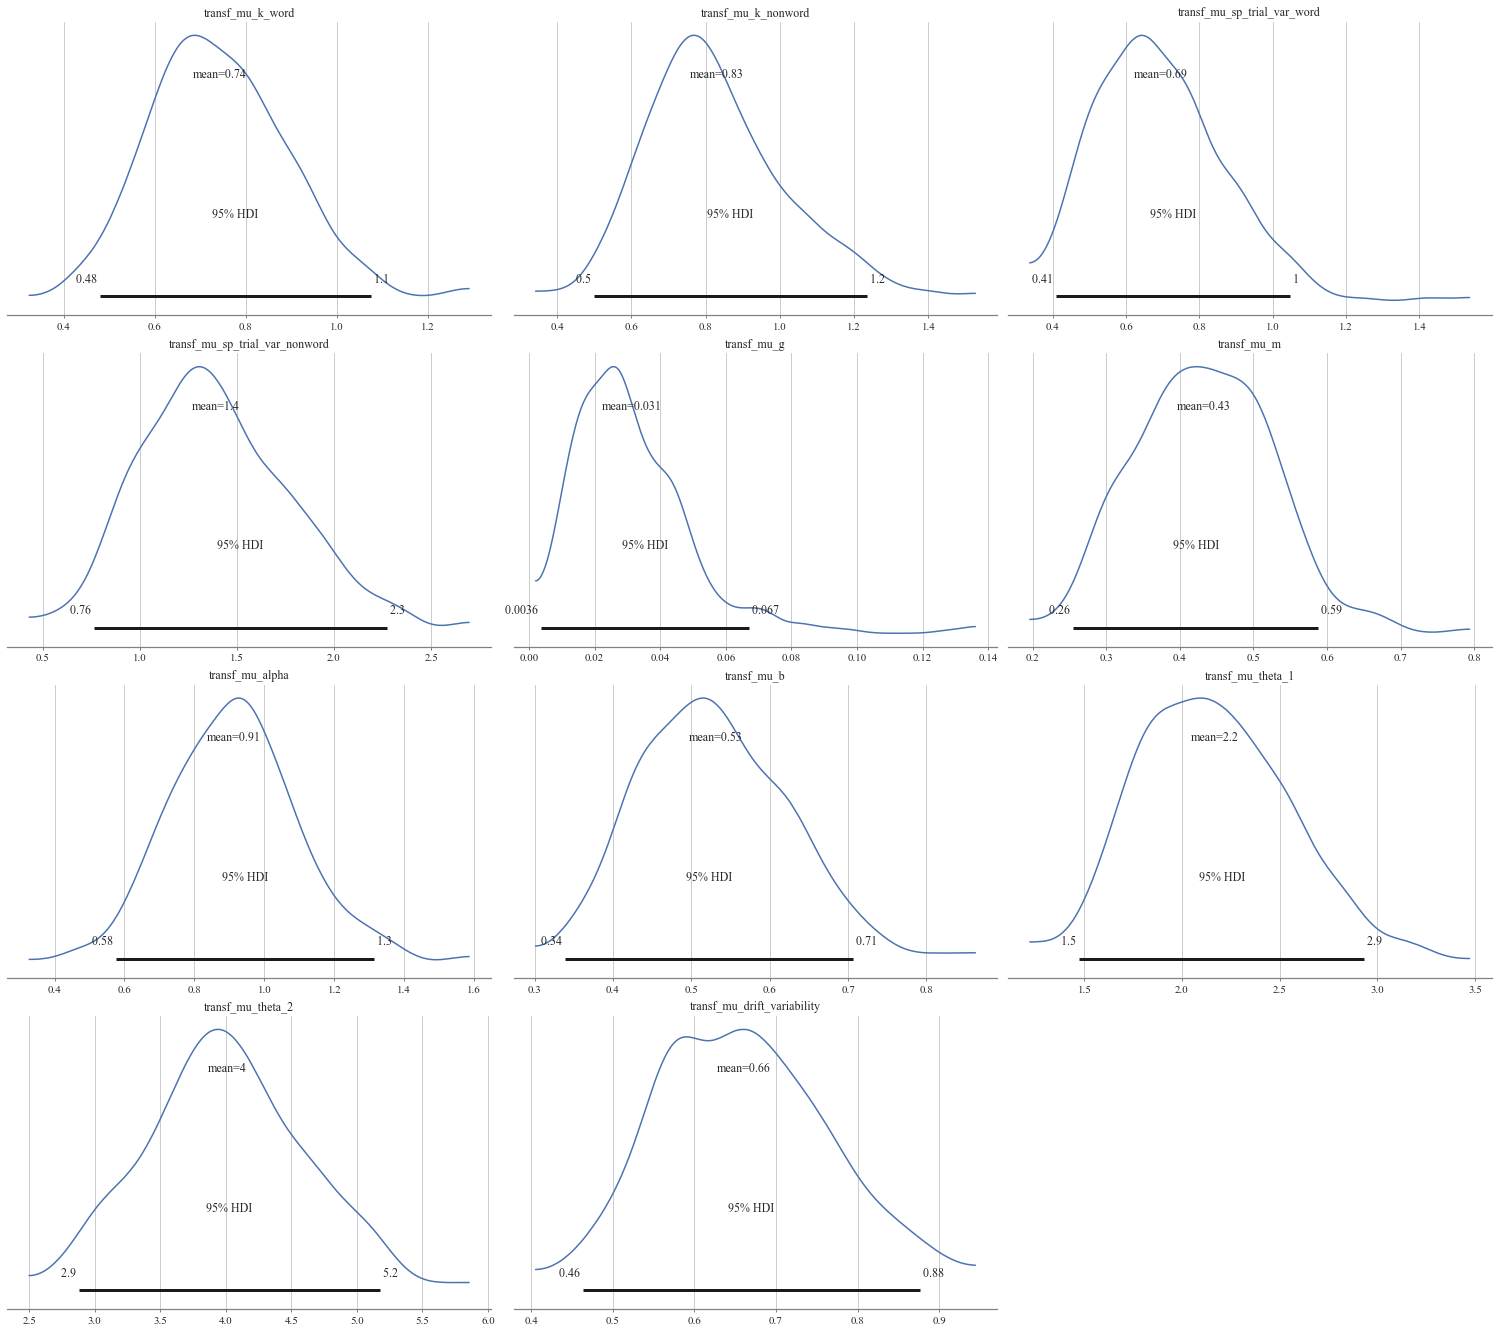

In [13]:
az.plot_posterior(fit, var_names=model_config['transf_params'],
                  hdi_prob=.95);
plt.savefig(plots_path + 'Parameters.pdf')

Loading model parameters for each trial

In [14]:
drift_word_t = fit.stan_variables()['drift_word_t']
drift_nonword_t = fit.stan_variables()['drift_nonword_t']
ndt_t = fit.stan_variables()['ndt_t']
drift_variability_t = fit.stan_variables()['drift_variability_t']
if model_config['model_name'] != "LBA":
    k_t_word = fit.stan_variables()['k_t_word']
    k_t_nonword = fit.stan_variables()['k_t_nonword']
    sp_t_word = fit.stan_variables()['sp_trial_var_t_word']
    sp_t_nonword = fit.stan_variables()['sp_trial_var_t_nonword']

else:
    k_t = fit.stan_variables()['k_t']
    sp_trial_var_t = fit.stan_variables()['sp_trial_var_t']

#### Models mean parameters in different conditions

In [15]:
v_HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
v_HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
v_LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
v_LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
v_NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
v_NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [16]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(v_HF_condition_w, axis=1)), np.std(np.mean(v_HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(v_HF_condition_nw, axis=1)), np.std(np.mean(v_HF_condition_nw, axis=1)))
print('LF words word drift mean and std:')
print(np.mean(np.mean(v_LF_condition_w, axis=1)), np.std(np.mean(v_LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(v_LF_condition_nw, axis=1)), np.std(np.mean(v_LF_condition_nw, axis=1)))
print('NW words word drift mean and std:')
print(np.mean(np.mean(v_NW_condition_w, axis=1)), np.std(np.mean(v_NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(v_NW_condition_nw, axis=1)), np.std(np.mean(v_NW_condition_nw, axis=1)))

HF words, word drift mean and std:
2.4393112742175145 0.38523558629248306
HF words, nonword drift mean and std:
1.6067466368870058 0.2505638480064242
LF words word drift mean and std:
1.9057619790422837 0.3031167688547151
LF words nonword drift mean and std:
1.6170563102494717 0.25173374608161936
NW words word drift mean and std:
0.8503568754793714 0.14528269204830707
NW words nonword drift mean and std:
2.5314592031473477 0.3829006064968054


In [17]:
if model_config['model_name'] != "LBA":
    sp_HF_condition_w = sp_t_word[:, behavioural_df['category']=="HF"]
    sp_HF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="HF"]
    sp_LF_condition_w = sp_t_word[:, behavioural_df['category']=="LF"]
    sp_LF_condition_nw = sp_t_nonword[:, behavioural_df['category']=="LF"]
    sp_NW_condition_w = sp_t_word[:, behavioural_df['category']=="NW"]
    sp_NW_condition_nw = sp_t_nonword[:, behavioural_df['category']=="NW"]
else:
    sp_HF_condition = sp_trial_var_t[:, behavioural_df['category']=="HF"]
    sp_LF_condition = sp_trial_var_t[:, behavioural_df['category']=="LF"]
    sp_NW_condition = sp_trial_var_t[:, behavioural_df['category']=="NW"]

In [18]:
if model_config['model_name'] != "LBA":
    print('HF words, word starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_w, axis=1)), np.std(np.mean(sp_HF_condition_w, axis=1)))
    print('HF words, nonword starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition_nw, axis=1)), np.std(np.mean(sp_HF_condition_nw, axis=1)))
    print('LF words word starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_w, axis=1)), np.std(np.mean(sp_LF_condition_w, axis=1)))
    print('LF words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition_nw, axis=1)), np.std(np.mean(sp_LF_condition_nw, axis=1)))
    print('NW words word starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_w, axis=1)), np.std(np.mean(sp_NW_condition_w, axis=1)))
    print('NW words nonword starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition_nw, axis=1)), np.std(np.mean(sp_NW_condition_nw, axis=1)))
else:
    print('HF words, starting point mean and std:')
    print(np.mean(np.mean(sp_HF_condition, axis=1)), np.std(np.mean(sp_HF_condition, axis=1)))
    print('LF words starting point mean and std:')
    print(np.mean(np.mean(sp_LF_condition, axis=1)), np.std(np.mean(sp_LF_condition, axis=1)))
    print('NW words starting point mean and std:')
    print(np.mean(np.mean(sp_NW_condition, axis=1)), np.std(np.mean(sp_NW_condition, axis=1)))

HF words, word starting point mean and std:
0.6962102114355934 0.1303100875646639
HF words, nonword starting point mean and std:
1.56771626200517 0.2536314609980277
LF words word starting point mean and std:
0.7138476383078225 0.13432603822791744
LF words nonword starting point mean and std:
1.6351889505821147 0.26487134543747787
NW words word starting point mean and std:
0.6932631075961687 0.12796901288126344
NW words nonword starting point mean and std:
1.5053952940226911 0.24276683136638047


In [19]:
if model_config['model_name'] != "LBA":
    k_HF_condition_w = k_t_word[:, behavioural_df['category']=="HF"]
    k_HF_condition_nw = k_t_nonword[:, behavioural_df['category']=="HF"]
    k_LF_condition_w = k_t_word[:, behavioural_df['category']=="LF"]
    k_LF_condition_nw = k_t_nonword[:, behavioural_df['category']=="LF"]
    k_NW_condition_w = k_t_word[:, behavioural_df['category']=="NW"]
    k_NW_condition_nw = k_t_nonword[:, behavioural_df['category']=="NW"]

    t_HF_condition_w = sp_HF_condition_w + sp_HF_condition_w
    t_HF_condition_nw = sp_HF_condition_nw + sp_HF_condition_nw
    t_LF_condition_w = sp_LF_condition_w + sp_LF_condition_w
    t_LF_condition_nw = sp_LF_condition_nw + sp_LF_condition_nw
    t_NW_condition_w = sp_NW_condition_w + sp_NW_condition_w
    t_NW_condition_nw = sp_NW_condition_nw + sp_NW_condition_nw
else:
    k_HF_condition = k_t[:, behavioural_df['category']=="HF"]
    k_LF_condition = k_t[:, behavioural_df['category']=="LF"]
    k_NW_condition = k_t[:, behavioural_df['category']=="NW"]

    t_HF_condition = sp_HF_condition + k_HF_condition
    t_LF_condition = sp_LF_condition + k_LF_condition
    t_NW_condition = sp_NW_condition + k_NW_condition

In [20]:
if model_config['model_name'] != "LBA":
    print('HF words, word threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_w, axis=1)), np.std(np.mean(t_HF_condition_w, axis=1)))
    print('HF words, nonword threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition_nw, axis=1)), np.std(np.mean(t_HF_condition_nw, axis=1)))
    print('LF words word threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_w, axis=1)), np.std(np.mean(t_LF_condition_w, axis=1)))
    print('LF words nonword threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition_nw, axis=1)), np.std(np.mean(t_LF_condition_nw, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_w, axis=1)), np.std(np.mean(t_NW_condition_w, axis=1)))
    print('NW words nonword threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition_nw, axis=1)), np.std(np.mean(t_NW_condition_nw, axis=1)))
else:
    print('HF words,  threshold mean and std:')
    print(np.mean(np.mean(t_HF_condition, axis=1)), np.std(np.mean(t_HF_condition, axis=1)))
    print('LF words threshold mean and std:')
    print(np.mean(np.mean(t_LF_condition, axis=1)), np.std(np.mean(t_LF_condition, axis=1)))
    print('NW words word threshold mean and std:')
    print(np.mean(np.mean(t_NW_condition, axis=1)), np.std(np.mean(t_NW_condition, axis=1)))

HF words, word threshold mean and std:
1.3924204228711867 0.2606201751293278
HF words, nonword threshold mean and std:
3.13543252401034 0.5072629219960554
LF words word threshold mean and std:
1.427695276615645 0.2686520764558349
LF words nonword threshold mean and std:
3.2703779011642293 0.5297426908749557
NW words word threshold mean and std:
1.3865262151923374 0.2559380257625269
NW words nonword threshold mean and std:
3.0107905880453822 0.48553366273276094


In [21]:
if model_config['model_name'] != "LBA":
    bias_HF_condition_w = t_HF_condition_w - sp_HF_condition_w
    bias_HF_condition_nw = t_HF_condition_nw - sp_HF_condition_nw
    bias_LF_condition_w = t_LF_condition_w - sp_LF_condition_w
    bias_LF_condition_nw = t_LF_condition_nw - sp_LF_condition_nw
    bias_NW_condition_w = t_NW_condition_w - sp_NW_condition_w
    bias_NW_condition_nw = t_NW_condition_nw - sp_NW_condition_nw

In [22]:
if model_config['model_name'] != "LBA":
    print('HF words, word bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_w, axis=1)), np.std(np.mean(bias_HF_condition_w, axis=1)))
    print('HF words, nonword bias mean and std:')
    print(np.mean(np.mean(bias_HF_condition_nw, axis=1)), np.std(np.mean(bias_HF_condition_nw, axis=1)))
    print('LF words word bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_w, axis=1)), np.std(np.mean(bias_LF_condition_w, axis=1)))
    print('LF words nonword bias mean and std:')
    print(np.mean(np.mean(bias_LF_condition_nw, axis=1)), np.std(np.mean(bias_LF_condition_nw, axis=1)))
    print('NW words word bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_w, axis=1)), np.std(np.mean(bias_NW_condition_w, axis=1)))
    print('NW words nonword bias mean and std:')
    print(np.mean(np.mean(bias_NW_condition_nw, axis=1)), np.std(np.mean(bias_NW_condition_nw, axis=1)))

HF words, word bias mean and std:
0.6962102114355934 0.1303100875646639
HF words, nonword bias mean and std:
1.56771626200517 0.2536314609980277
LF words word bias mean and std:
0.7138476383078225 0.13432603822791744
LF words nonword bias mean and std:
1.6351889505821147 0.26487134543747787
NW words word bias mean and std:
0.6932631075961687 0.12796901288126344
NW words nonword bias mean and std:
1.5053952940226911 0.24276683136638047


In [23]:
ndt_HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
ndt_LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
ndt_NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [24]:
print('HF words ndt mean and std:')
print(np.mean(np.mean(ndt_HF_condition, axis=1)), np.std(np.mean(ndt_HF_condition, axis=1)))
print('LF words ndt mean and std:')
print(np.mean(np.mean(ndt_LF_condition, axis=1)), np.std(np.mean(ndt_LF_condition, axis=1)))
print('Non Words ndt mean and std:')
print(np.mean(np.mean(ndt_NW_condition, axis=1)), np.std(np.mean(ndt_NW_condition, axis=1)))

HF words ndt mean and std:
0.19452012920621467 0.015228697282945904
LF words ndt mean and std:
0.19458051618181813 0.015222234399930503
Non Words ndt mean and std:
0.20337749026326143 0.01600169672635042


## Calculating metrics

In [25]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [26]:
log_likelihood = fit.stan_variables()['log_lik']
print(calculate_waic(log_likelihood))

{'lppd': -506.9484888810793, 'p_waic': 73.3346235975354, 'waic': 1160.5662249572295, 'waic_se': 155.54349870787996}


## Simulating LBA with estimated parameters

In [27]:
def random_lba_2A(word_drift, nonword_drift, sp_trial_var_word, sp_trial_var_nonword,
                  ndt, k_word, k_nonword, drift_trial_var):
    """Simulates behavior (rt and accuracy) according to the Linear Ballistic Accumulator.
    Parameters
    ----------
    word_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - correct responses. 1D array of floats.
    nonword_drift : numpy.ndarray
        Drift-rate of the Linear Ballistic Accumulator - incorrect responses. 1D array of floats.
    sp_trial_var_word : float
        Starting point variability of the Linear Ballistic Accumulator for words. Also called A.
    sp_trial_var_nonword : float
        Starting point variability of the Linear Ballistic Accumulator for non-words. Also called A.    
    ndt : float
        Non-decision time of the Linear Ballistic Accumulator. Also called tau.
    k_word : float
        Distance between starting point variability and threshold for words.
    k_nonword : float
        Distance between starting point variability and threshold for non-words.
    drift_trial_var : numpy.ndarray, default None
        The drift rate trial variability. 1D array of 0s and 1s.
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    resp: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response according to the Linear Ballistic Accumulator.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = word_drift.shape
    resp = np.empty(shape)
    rt = np.empty(shape)
    resp[:] = np.nan
    rt[:] = np.nan

    b_word = k_word + sp_trial_var_word
    b_nonword = k_nonword + sp_trial_var_nonword
    one_pose = True
    v_word = np.array(word_drift)
    v_nonword = np.array(nonword_drift)

    # this while loop might be wrong
    while one_pose:
        ind = np.logical_and(v_word < 0, v_nonword < 0)
        if drift_trial_var is None:
            v_word[ind] = np.random.normal(word_drift[ind], np.ones(word_drift[ind].shape))
            v_nonword[ind] = np.random.normal(nonword_drift[ind], np.ones(nonword_drift[ind].shape))
        else:
            v_word[ind] = np.random.normal(word_drift[ind], drift_trial_var[ind])
            v_nonword[ind] = np.random.normal(nonword_drift[ind], drift_trial_var[ind])

        one_pose = np.sum(ind) > 0

    start_word = np.random.uniform(np.zeros(sp_trial_var_word.shape), sp_trial_var_word)
    start_non_word = np.random.uniform(np.zeros(sp_trial_var_nonword.shape), sp_trial_var_nonword)

    ttf_word = (b_word - start_word) / v_word
    ttf_nonword = (b_nonword - start_non_word) / v_nonword

    ind = np.logical_and(ttf_word <= ttf_nonword, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < 0, 0 < ttf_word)
    resp[ind] = 1
    rt[ind] = ttf_word[ind] + ndt[ind]

    ind = np.logical_and(ttf_nonword < ttf_word, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    ind = np.logical_and(ttf_word < 0, 0 < ttf_nonword)
    resp[ind] = 0
    rt[ind] = ttf_nonword[ind] + ndt[ind]

    return rt, resp

Simulating RDM with estimated parameters

In [28]:
if model_config['model_name'] != "LBA":
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_t_word, sp_t_nonword,
                                       ndt_t, k_t_word, k_t_nonword, drift_variability_t)
else:
    pp_rt, pp_response = random_lba_2A(drift_word_t, drift_nonword_t, sp_trial_var_t, sp_trial_var_t,
                                       ndt_t, k_t, k_t, drift_variability_t)

In [29]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [30]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [31]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF'].drop(['category'], axis=1)
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF'].drop(['category'], axis=1)
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF'].drop(['category'], axis=1)
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF'].drop(['category'], axis=1)
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW'].drop(['category'], axis=1)
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW'].drop(['category'], axis=1)

## Quantiles Posterior Predictions

In [32]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [33]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

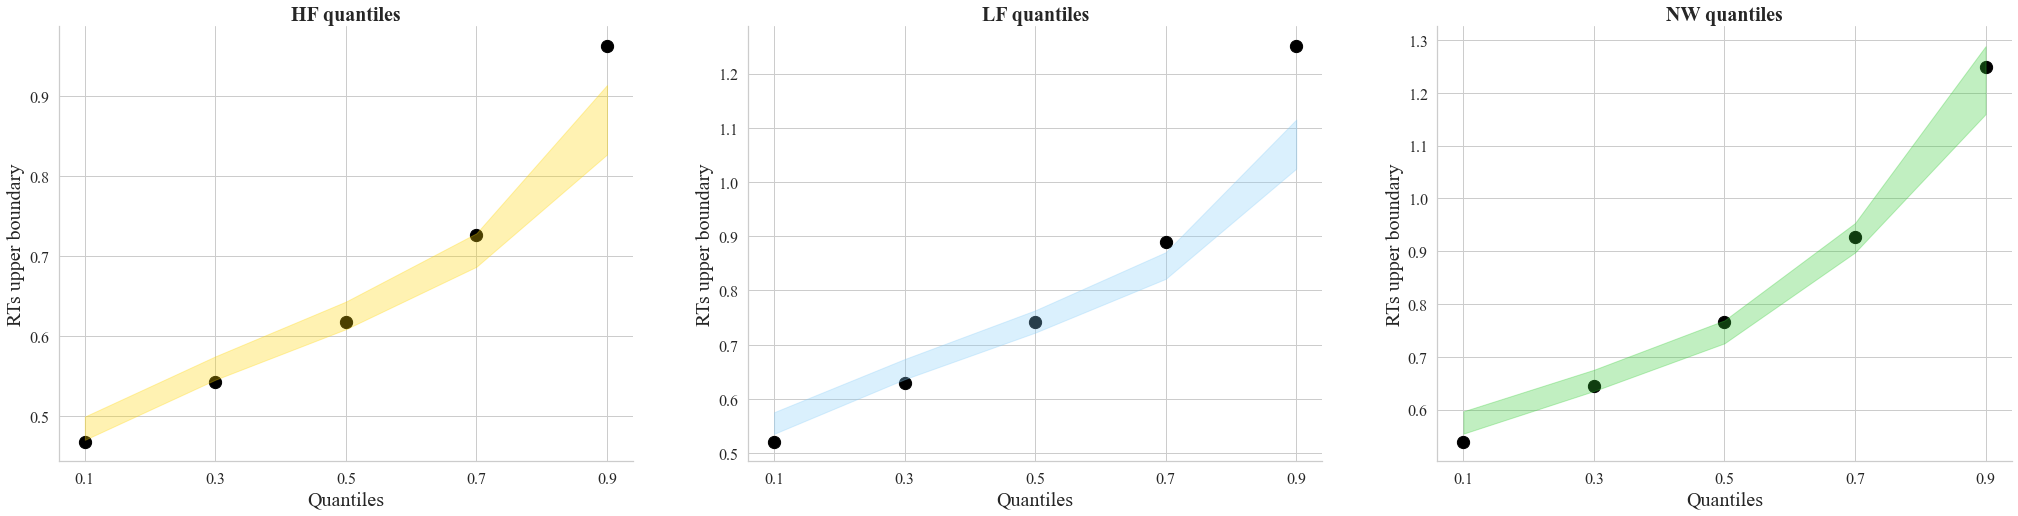

In [34]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title('HF quantiles', fontweight="bold", size=20)
axes[1].set_title('LF quantiles', fontweight="bold", size=20)
axes[2].set_title('NW quantiles', fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color='black', s=150)
axes[1].scatter(quantiles, LF_quantile_ex, color='black', s=150)
axes[2].scatter(quantiles, NW_quantile_ex, color='black', s=150)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'gold', alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'lightskyblue', alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'limegreen', alpha=0.3)


for ax in axes:
        ax.set_xlabel('Quantiles', fontsize=20)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary', fontsize=20)
        for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(16)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16) 

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior.pdf')

## Mean Accuracy and RT Posterior Plots

In [35]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [36]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)], color = 'lightsteelblue')

    ax.plot(xd, yd, color='slategray')
    ax.axvline(data_mean, color='red')

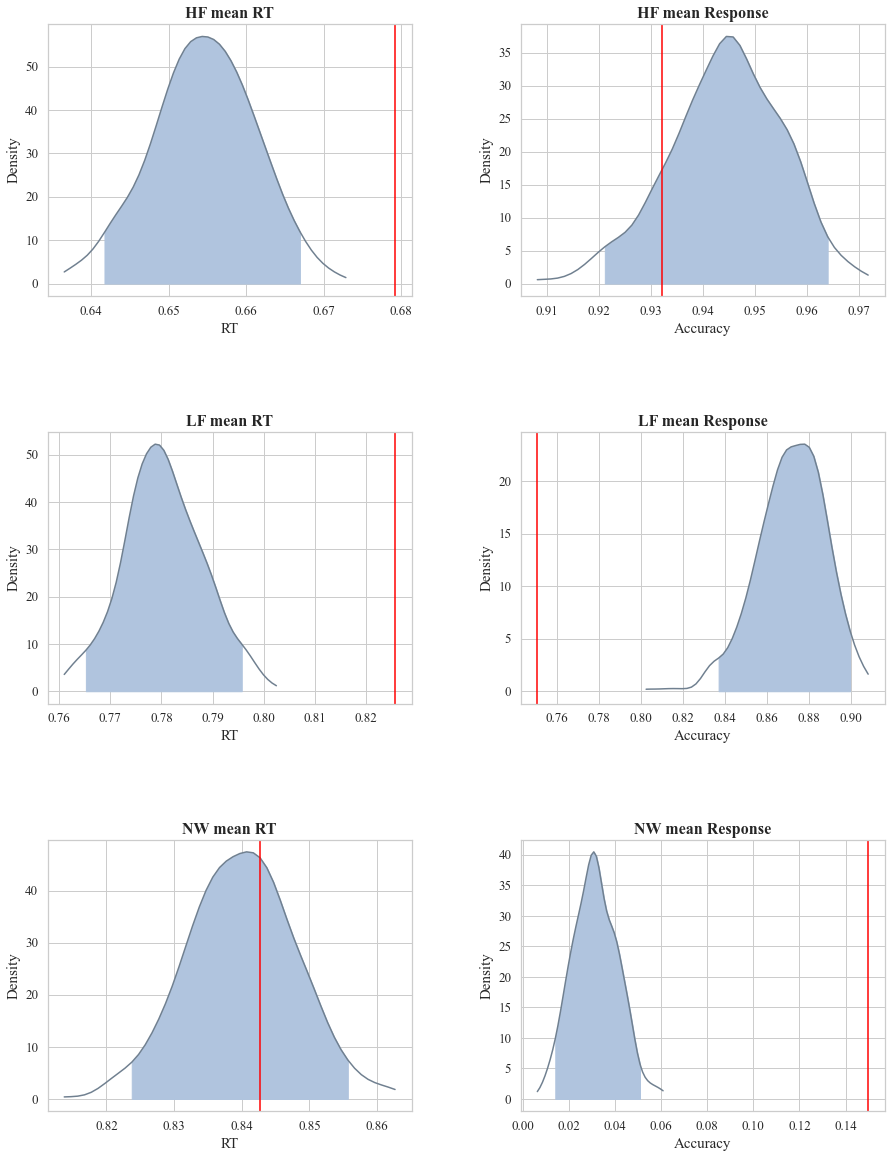

In [37]:
fig, axes = plt.subplots(3,2 , figsize=(15,20))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title('HF mean RT', fontweight="bold", size=16)
axes[0][1].set_title('HF mean Response', fontweight="bold", size=16)
axes[1][0].set_title('LF mean RT', fontweight="bold", size=16)
axes[1][1].set_title('LF mean Response', fontweight="bold", size=16)
axes[2][0].set_title('NW mean RT', fontweight="bold", size=16)
axes[2][1].set_title('NW mean Response', fontweight="bold", size=16)

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel('RT', fontsize=15)
        ax[1].set_xlabel('Accuracy', fontsize=15)
        ax[0].set_ylabel('Density', fontsize=15)
        ax[1].set_ylabel('Density', fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
                tick.label.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

plt.savefig(plots_path + 'Mean Accuracy and RT.pdf')